## Business Undestanding


### Bestimmung der Problemstellung: 
Hier wird an den Anwender die Anforderung gestellt, das Data Mining Projekt betriebswirtschaftlich auszurichten. Dabei werden die operationalen und betriebswirtschaftlichen Zielkriterien formuliert.
>Bei der vorliegenden Projektaufgabe gilt es, drei Prognosemodelle zu erstellen, um auf Basis der vorliegenden Daten zu den Brunnen bestimmen zu können, welche der gegebenen Brunnen funktionieren, welche nicht und welche repariert werden müssen. Dabei soll anhand der ML-Pipeline, aufbauend auf dem CRISP-DM Modell, vorgegangen werden und die Güte der einzelnen Modelle anhand der Area-Under-Curve (AUC) auf den Testdaten qualifiziert werden. 



### Bestimmung analytischer Ziele:
Ausgehend von der zuvor bestimmten Problemdefinition müssen dazu die erforderlichen Datenanalyseaufgaben ermittelt werden. Zudem müssen die Erfolgskriterien für das Data Mining-Projekt bestimmt werden.
>Prognosemodell welche Brunnen funktionieren und welche nicht

>Prognosemodell für die Brunnen die repariert werden müssen 

>Prognosemodell, das zwischen allen drei Klassen unterscheidet

#### Vorgehen:
<ol>
    <li> Datenanalyse
    <li> Feature Engineering
    <li> Model Selection
    <li> Erstellung + Hyperparameter-Tuning von drei binären Modellen
    <li> Zusammenführung in ein Multilabel-Model
    <li> Evaluation der Güte der Models
</ol>

## Data Understanding


### Daten sammeln: 
Hier werden die benötigten Daten für die Analyse beschaffen und, wenn erforderlich, in bereits bestehende Datenmengen integriert. Dabei sollten Probleme, die bei der Datenbeschaffung auftreten, stets dokumentiert werden, um mögliche Diskrepanzen bei einem Folgeprojekt in der Zukunft zu vermeiden.

Im folgenden werden alle vorhandenen Daten der Trainings- und Testdatensätze aufgelistet:

>amount_tsh - Total static head (amount water available to waterpoint)

>date_recorded - The date the row was entered

>funder - Who funded the well

>gps_height - Altitude of the well

>installer - Organization that installed the well

>longitude - GPS coordinate

>latitude - GPS coordinate 

>wpt_name - Name of the waterpoint if there is one

>num_private -

>basin - Geographic water basin

>subvillage - Geographic location

>region - Geographic location

>region_code - Geographic location (coded)

>district_code - Geographic location (coded)

>lga - Geographic location

>ward - Geographic location

>population - Population around the well

>public_meeting - True/False

>recorded_by - Group entering this row of data

>scheme_management - Who operates the waterpoint

>scheme_name - Who operates the waterpoint

>permit - If the waterpoint is permitted

>construction_year - Year the waterpoint was constructed

>extraction_type - The kind of extraction the waterpoint uses

>extraction_type_group - The kind of extraction the waterpoint uses

>extraction_type_class - The kind of extraction the waterpoint uses

>management - How the waterpoint is managed

>management_group - How the waterpoint is managed

>payment - What the water costs

>payment_type - What the water costs

>water_quality - The quality of the water

>quality_group - The quality of the water

>quantity - The quantity of water

>quantity_group - The quantity of water

>source - The source of the water

>source_type - The source of the water

>source_class - The source of the water 


> Bei der Beschreibung der einzelnen Merkmale, und somit der einzelnen Spalten, des Datensatzes fällt auf, dass die Beschreibungen der einzelnen Merkmale öfters doppelt vorkommen. Zum Beispiel haben die Merkmale quantity und quantity_group genau dieselbe Beschreibung. Daraus lässt sich schließen, dass zweiteres Merkmal eventuell "nur" eine Gruppierung des ersteren ist. 

> Diese Merkmale könnten eventuell in der Data Preparation dann entfernt werden.

#### Imports

In [1]:
# imports
# for data understanding
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# for data preparation
from utils import Dataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

# for modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

# for hyperparameter-tuning and evaluation
from tqdm import tqdm
from itertools import product
from utils import one_vs_all, get_prob_and_pred
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# for deployment
from pickle import dump

#### Einlesen der Training- und Test-Datensets

In [2]:
# read the csv files / datasets into a pandas dataframe
train_data = pd.read_csv("pump_train.csv")
test_data = pd.read_csv("pump_test.csv")

### Daten beschreiben: 
In diesem Schritt gilt es, ein allgemeines Verständnis für die Daten zu erlangen. Zudem werden die Eigenschaften der Daten beschrieben, wie z.B. Quantität der Daten, Formateigenschaften, Anzahl der Einträge und Felder sowie Eigenschaften der Felder. Die entscheidende Frage ist, ob die vorliegenden Daten der Datenanalyse genügen, um das Projekt erfolgreich abzuschließen.


In [3]:
# using different functions of pandas to describe the dataset better
train_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [4]:
print("Train data rows, columns:",train_data.shape)
print("Test data rows, columns:", test_data.shape)

Train data rows, columns: (50490, 41)
Test data rows, columns: (8910, 41)


In [5]:
train_data.head(10)

id  amount_tsh date_recorded                          funder  \
0  12237        30.0    2013-01-23          Government Of Tanzania   
1  24566         0.0    2013-02-07              Private Individual   
2  20536         0.0    2011-07-15                          Sawaka   
3  30633       200.0    2011-03-25          Government Of Tanzania   
4   2993         0.0    2011-02-17           African Muslim Agency   
5  41668         0.0    2013-02-15                      Nyitamboka   
6  61839         0.0    2013-02-09                           Rwssp   
7  62441         0.0    2011-02-21          Government Of Tanzania   
8  53492         0.0    2012-10-18  Member Of Perliament Ahmed Ali   
9  54314         0.0    2011-08-01      The Desk And Chair Foundat   

   gps_height                       installer  longitude   latitude  \
0         107                District Council  39.360880 -10.295705   
1           0                          Edward  32.644074  -3.859265   
2           0                             DWE  30.999792  -1.721771   
3        2142                           Commu  34.060324  -9.335288   
4         290                District Council  38.862874  -7.165410   
5        1229                      Nyitamboka  34.349079  -1.630274   
6           0                             DWE  32.586745  -3.815508   
7          75                           Centr  39.010886  -7.615327   
8           0  Member of Perliament Ahmed Ali  33.165581  -3.796312   
9           0      The desk and chair foundat  33.326639  -3.027799   

                    wpt_name  num_private  ... water_quality quality_group  \
0             Zahanati Membe            0  ...          soft          good   
1              Kwa Mama Wini            0  ...          soft          good   
2                   Kwasimon            0  ...          soft          good   
3                       none            0  ...          soft          good   
4                  Msikitini            0  ...          soft          good   
5       Nyitamboka Kitanyita            0  ...         salty         salty   
6                      Idete            0  ...         milky         milky   
7  Nyambili Primary School 2            0  ...          soft          good   
8            Kwa Hima Ganaye            0  ...          soft          good   
9                    Nguruko            0  ...          soft          good   

       quantity  quantity_group        source   source_type source_class  \
0        enough          enough         river    river/lake      surface   
1  insufficient    insufficient  shallow well  shallow well  groundwater   
2        enough          enough  shallow well  shallow well  groundwater   
3        enough          enough        spring        spring  groundwater   
4           dry             dry   machine dbh      borehole  groundwater   
5        enough          enough  shallow well  shallow well  groundwater   
6           dry             dry  shallow well  shallow well  groundwater   
7        enough          enough        spring        spring  groundwater   
8  insufficient    insufficient  shallow well  shallow well  groundwater   
9        enough          enough  shallow well  shallow well  groundwater   

               waterpoint_type waterpoint_type_group    status_group  
0  communal standpipe multiple    communal standpipe      functional  
1                        other                 other      functional  
2                        other                 other  non functional  
3           communal standpipe    communal standpipe      functional  
4                    hand pump             hand pump  non functional  
5                    hand pump             hand pump      functional  
6                        other                 other  non functional  
7           communal standpipe    communal standpipe  non functional  
8                    hand pump             hand pump      functional  
9                    hand pump             hand

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50490 entries, 0 to 50489
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50490 non-null  int64  
 1   amount_tsh             50490 non-null  float64
 2   date_recorded          50490 non-null  object 
 3   funder                 47396 non-null  object 
 4   gps_height             50490 non-null  int64  
 5   installer              47380 non-null  object 
 6   longitude              50490 non-null  float64
 7   latitude               50490 non-null  float64
 8   wpt_name               50490 non-null  object 
 9   num_private            50490 non-null  int64  
 10  basin                  50490 non-null  object 
 11  subvillage             50175 non-null  object 
 12  region                 50490 non-null  object 
 13  region_code            50490 non-null  int64  
 14  district_code          50490 non-null  int64  
 15  lg

In [7]:
train_data.describe().T

count          mean           std        min  \
id                 50490.0  37113.857695  21447.241039   0.000000   
amount_tsh         50490.0    319.158123   2987.517185   0.000000   
gps_height         50490.0    669.714280    693.123330 -90.000000   
longitude          50490.0     34.078591      6.553382   0.000000   
latitude           50490.0     -5.708336      2.943806 -11.648378   
num_private        50490.0      0.459497     10.413455   0.000000   
region_code        50490.0     15.280511     17.550035   1.000000   
district_code      50490.0      5.641731      9.668596   0.000000   
population         50490.0    180.913389    479.854870   0.000000   
construction_year  50490.0   1301.724520    951.258506   0.000000   

                            25%           50%           75%           max  
id                 18517.250000  37027.500000  55636.750000  7.424700e+04  
amount_tsh             0.000000      0.000000     20.000000  3.500000e+05  
gps_height             0.000000    371.000000   1322.000000  2.770000e+03  
longitude             33.084409     34.906548     37.178899  4.034519e+01  
latitude              -8.541643     -5.019807     -3.327550 -2.000000e-08  
num_private            0.000000      0.000000      0.000000  1.402000e+03  
region_code            5.000000     12.000000     17.000000  9.900000e+01  
district_code          2.000000      3.000000      5.000000  8.000000e+01  
population             0.000000     25.000000    215.750000  3.050000e+04  
construction_year      0.000000   1986.000000   2004.000000  2.013000e+03

In [85]:
# checking how many different values are there in each column in %
uniques = train_data.nunique().sort_values() 
pd.concat([uniques, uniques/len(train_data)*100], axis=1, keys=['abs', '%'])

abs           %
recorded_by                1    0.001981
public_meeting             2    0.003961
permit                     2    0.003961
status_group               3    0.005942
source_class               3    0.005942
quantity_group             5    0.009903
quantity                   5    0.009903
management_group           5    0.009903
quality_group              6    0.011884
waterpoint_type_group      6    0.011884
payment                    7    0.013864
extraction_type_class      7    0.013864
waterpoint_type            7    0.013864
source_type                7    0.013864
payment_type               7    0.013864
water_quality              8    0.015845
basin                      9    0.017825
source                    10    0.019806
management                12    0.023767
scheme_management         12    0.023767
extraction_type_group     13    0.025748
extraction_type           18    0.035651
district_code             20    0.039612
region                    21    0.041592
region_code               27    0.053476
date_recorded             38    0.075262
construction_year         55    0.108932
num_private               62    0.122797
amount_tsh                94    0.186175
lga                      125    0.247574
population               989    1.958804
funder                  1734    3.434343
installer               1964    3.889879
ward                    2085    4.129531
gps_height              2350    4.654387
scheme_name             2583    5.115865
subvillage             17774   35.203010
wpt_name               32390   64.151317
longitude              48914   96.878590
latitude               48916   96.882551
id                     50490  100.000000

In [9]:
(train_data.recorded_by=="GeoData Consultants Ltd").all() # shows that every value in 'recorded_by' is the same

True

> Hieran ist zu erkennen, dass die Selektivität der Merkmale / Attribute im Datensatz variiert. Werte mit sehr hoher Selektivität und diskrete Werte könnten für das weitere Vorgehen Schwierigkeiten mit sich bringen. Beispielsweise sind die Werte der ID (100%) alle unique, im Gegensatz dazu ist 'recorded_by' (0,001981%) bei allen gleich.

> Allgemein geht aus der Analyse der Daten oben hervor, dass der Trainingsdatensatz aus 50940 Zeilen à 41 Spalten und der Testdatensatz aus 8910 Zeile à 41 Spalten besteht. Dabei sind die Datentypen des Datensatzes hauptsächlich int, float und object.

### Untersuchung der Daten: 

#### Untersuchung des Trainingsdatensatzes auf fehlende Werte:

In [10]:
# checking for null values in the data set in absolute numbers and percentage
null_columns = train_data.isnull().sum().sort_values(ascending=False)
pd.concat([null_columns[null_columns!=0],null_columns[null_columns!=0]/len(train_data)*100], axis=1, keys=['abs', '%'])

abs          %
scheme_name        23942  47.419291
scheme_management   3269   6.474549
installer           3110   6.159636
funder              3094   6.127946
public_meeting      2846   5.636760
permit              2591   5.131709
subvillage           315   0.623886

#### Untersuchung des Testdatensatzes auf fehlende Werte:

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8910 entries, 0 to 8909
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     8910 non-null   int64  
 1   amount_tsh             8910 non-null   float64
 2   date_recorded          8910 non-null   object 
 3   funder                 8369 non-null   object 
 4   gps_height             8910 non-null   int64  
 5   installer              8365 non-null   object 
 6   longitude              8910 non-null   float64
 7   latitude               8910 non-null   float64
 8   wpt_name               8910 non-null   object 
 9   num_private            8910 non-null   int64  
 10  basin                  8910 non-null   object 
 11  subvillage             8854 non-null   object 
 12  region                 8910 non-null   object 
 13  region_code            8910 non-null   int64  
 14  district_code          8910 non-null   int64  
 15  lga 

In [12]:
test_data.head()

id  amount_tsh date_recorded   funder  gps_height installer  longitude  \
0  69572      6000.0    2011-03-14    Roman        1390     Roman  34.938093   
1   8776         0.0    2013-03-06  Grumeti        1399   GRUMETI  34.698766   
2  49056         0.0    2011-02-20  Private          62   Private  39.209518   
3  58155         0.0    2011-09-04   Unicef        1656       DWE  34.569266   
4  34169         0.0    2011-07-22   Hesawa        1162       DWE  32.920154   

   latitude         wpt_name  num_private  ... water_quality quality_group  \
0 -9.856322             none            0  ...          soft          good   
1 -2.147466         Zahanati            0  ...          soft          good   
2 -7.034139    Mzee Hokororo            0  ...         salty         salty   
3 -9.085515  Kwa Rose Chaula            0  ...          soft          good   
4 -1.947868           Ngomee            0  ...         milky         milky   

       quantity  quantity_group                source           source_type  \
0        enough          enough                spring                spring   
1  insufficient    insufficient  rainwater harvesting  rainwater harvesting   
2        enough          enough           machine dbh              borehole   
3           dry             dry                 river            river/lake   
4  insufficient    insufficient                spring                spring   

  source_class     waterpoint_type waterpoint_type_group  \
0  groundwater  communal standpipe    communal standpipe   
1      surface  communal standpipe    communal standpipe   
2  groundwater               other                 other   
3      surface  communal standpipe    communal standpipe   
4  groundwater               other                 other   

              status_group  
0               functional  
1               functional  
2               functional  
3           non functional  
4  functional needs repair  

[5 rows x 41 columns]

In [13]:
null_columns = test_data.isnull().sum().sort_values(ascending=False)
pd.concat([null_columns[null_columns!=0],null_columns[null_columns!=0]/len(test_data)*100], axis=1, keys=['abs', '%'])

abs          %
scheme_name        4224  47.407407
scheme_management   608   6.823793
installer           545   6.116723
funder              541   6.071829
public_meeting      488   5.476992
permit              465   5.218855
subvillage           56   0.628507

> In den Spalten funder, installer, subvillage, public_meeting, scheme_management, scheme_name und permit existieren fehlende Werte. Dabei handelt es sich bei allen Spalten um den Datentyp object. Diese fehlende Werte müssen in der Data Preparation ihrem Datentyp entsprechend später bereinigt bzw. aufgefüllt werden.

> Die Verteilung der fehlenden Werte in den seperaten Test- und Trainingsdatensätzen ist sehr ähnlich, was dafür spricht, dass die Verteilung beider Datensätze einer Grundgesamtheit entsprechen.

### Visualisierung der Daten:

Folgend wollen wir den Datensatz genauer visualisieren, das heißt wir wollen die Verteilung der einzelnen Merkmale und die Abhängigkeiten dieser untereinander genauer betrachten.

In [14]:
# defining colors for the plots
my_cmap = plt.get_cmap("Set2")

#### Histogramm der Merkmale

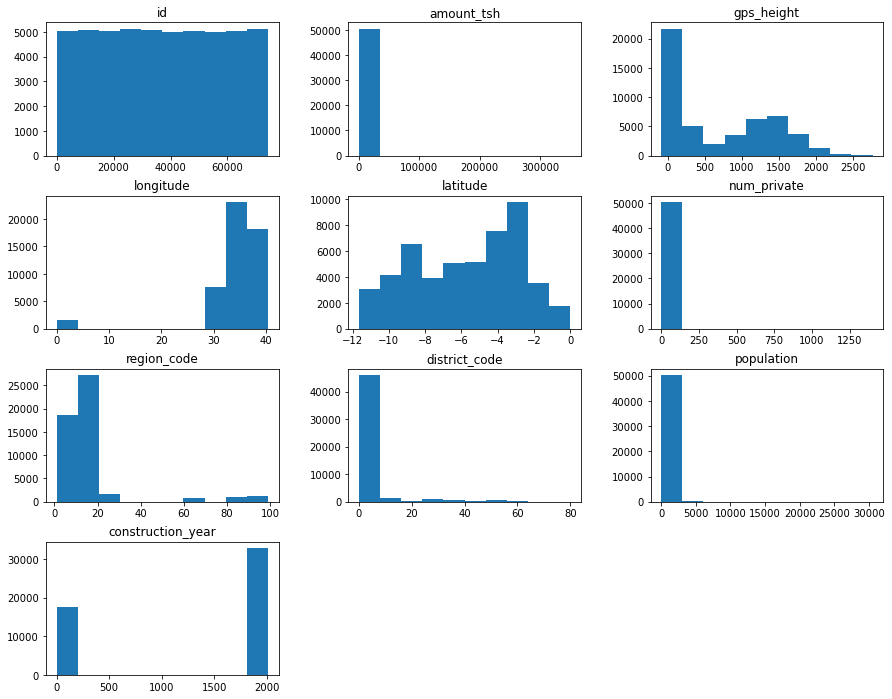

In [15]:
train_data.hist(bins=10,figsize=(15,12),grid=False);

> Im obigen Histogramm sind unterschiedliche Informationen zu den Datenpunkten abzulesen. Hierbei ist es ebenfalls möglich auf fehlende oder falsche Werte zu schließen. Bei der ID ist zu erkennen, dass es sich um eine fortlaufende Nummer handelt. Bei den Werten 'amount_tsh', 'num_private', 'district_code', 'population' sowie 'construction_year' ist die Hohe Anzahl im Nullwerte Bereich auffällig. 'latitude' und 'gps_height' sind beide über den Wertebereich verteilt aufgestellt.

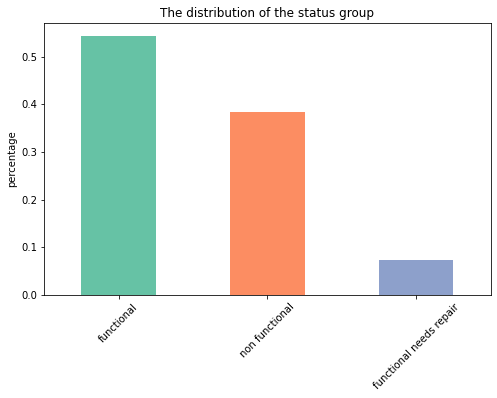

In [16]:
fig = plt.figure(figsize=(8,5))  
train_data.status_group.value_counts(normalize = "true").plot(kind="bar", title="The distribution of the status group", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

In [17]:
number= sum(train_data[train_data.status_group == 'functional'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number) + " Brunnen, die funktionieren.")
number1= sum(train_data[train_data.status_group == 'non functional'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number1) + " Brunnen, die nicht funktionieren.")
number2= sum(train_data[train_data.status_group == 'functional needs repair'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number2) + " Brunnen, die repariert werden müssen.")

Es gibt im Datensatz insgesamt 13663 Brunnen, die funktionieren.
Es gibt im Datensatz insgesamt 8275 Brunnen, die nicht funktionieren.
Es gibt im Datensatz insgesamt 1712 Brunnen, die repariert werden müssen.


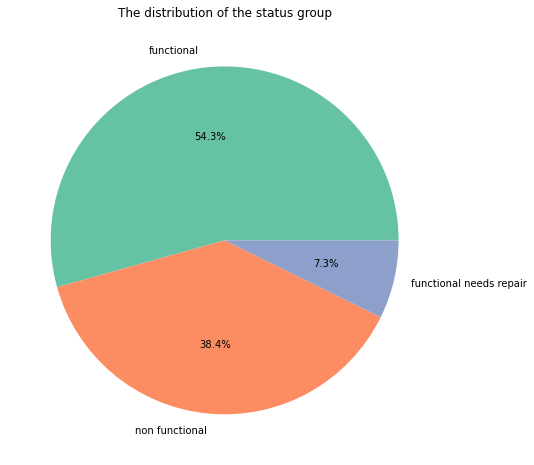

In [18]:
# making a pie chart
fig = plt.figure(figsize=(10,8)) 
train_data.status_group.value_counts(normalize = "true").plot(kind="pie", title="The distribution of the status group", autopct='%1.1f%%', colors=my_cmap.colors, label="")
plt.xticks(rotation=45);

>Wie in beiden Grafiken zu erkennen ist, sind über 50% der Brunnen funktionsfähig. Nahezu 40% sind nicht funktionsfähig und etwas weniger als 10% müssen repariert werden. Die Verteilung zeigt auf, dass nur die Hälfte aller Brunnen einsatzbereit sind um die Anwohner mit Wasser zu versorgen.

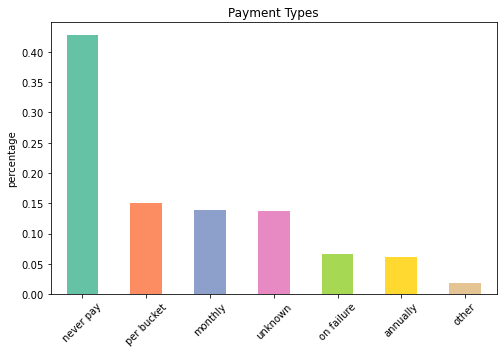

In [19]:
fig = plt.figure(figsize=(8,5))  
train_data.payment_type.value_counts(normalize = "true").plot(kind="bar", title="Payment Types", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

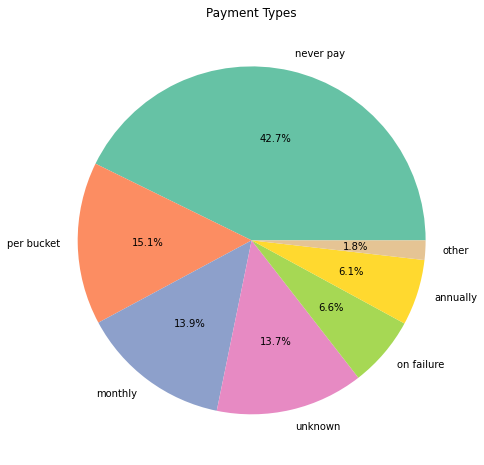

In [20]:
fig = plt.figure(figsize=(10,8))  
train_data.payment_type.value_counts(normalize = "true").plot(kind="pie", title="Payment Types", autopct='%1.1f%%', colors=my_cmap.colors, label="")
plt.xticks(rotation=45);

>Beide Visualisierungen stellen die Zahlungsmethoden da. Auffällig ist, dass es sehr viele unterschiedliche Zahlungsmethoden sind. Dennoch wird der Großteil durch 'never pay' vertreten. Auf den Kontext bezogen könnte dies erklären, warum viele Brunnen nicht weiter repariert oder berücksichigt werden, da einfach kein Geld vorliegt.

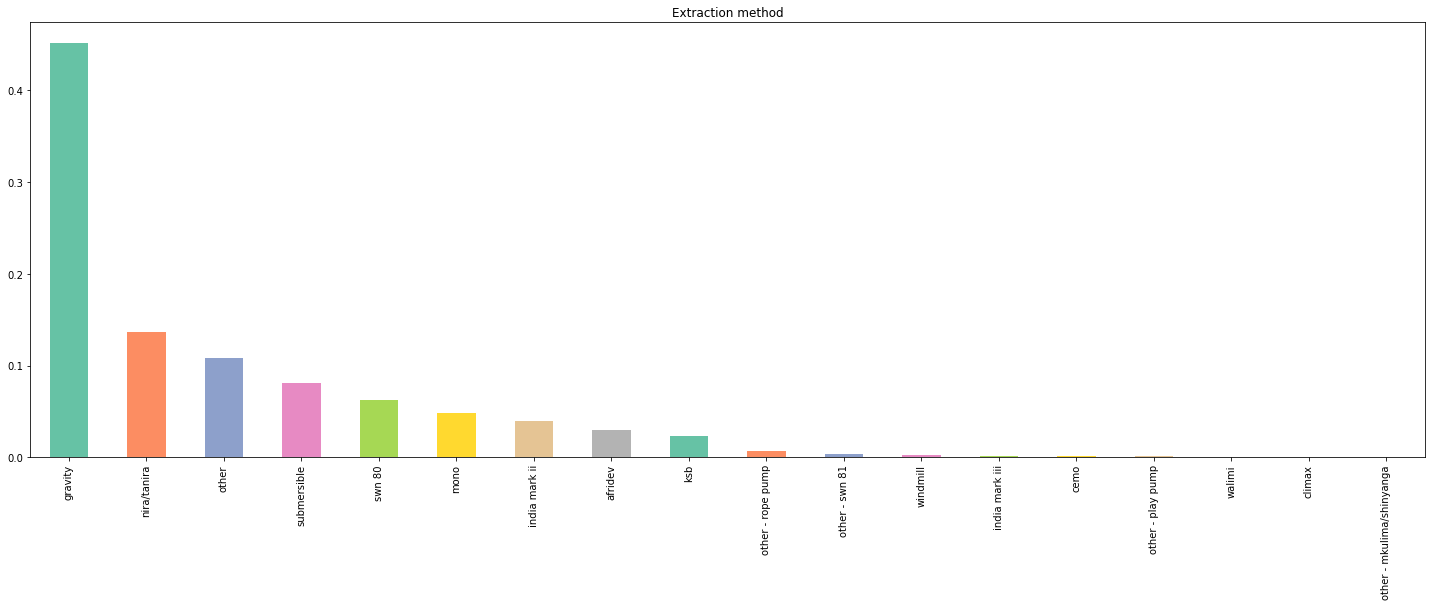

In [21]:
fig = plt.figure(figsize=(25,8))  
train_data.extraction_type.value_counts(normalize="True").plot(kind="bar", title="Extraction method", color=my_cmap.colors);

>Diese Grafik zeigt die Verteilung des Attributs 'extraction_type' auf. Dabei ist zu erkennen, dass die meisten Brunnen mit der Methode Gravity arbeiten, um an das Wasser zu gelangen. Auch ist auffällig, dass manche Extraction Types gar nicht genutzt werden, wie zum Beispiel walimi oder climax.

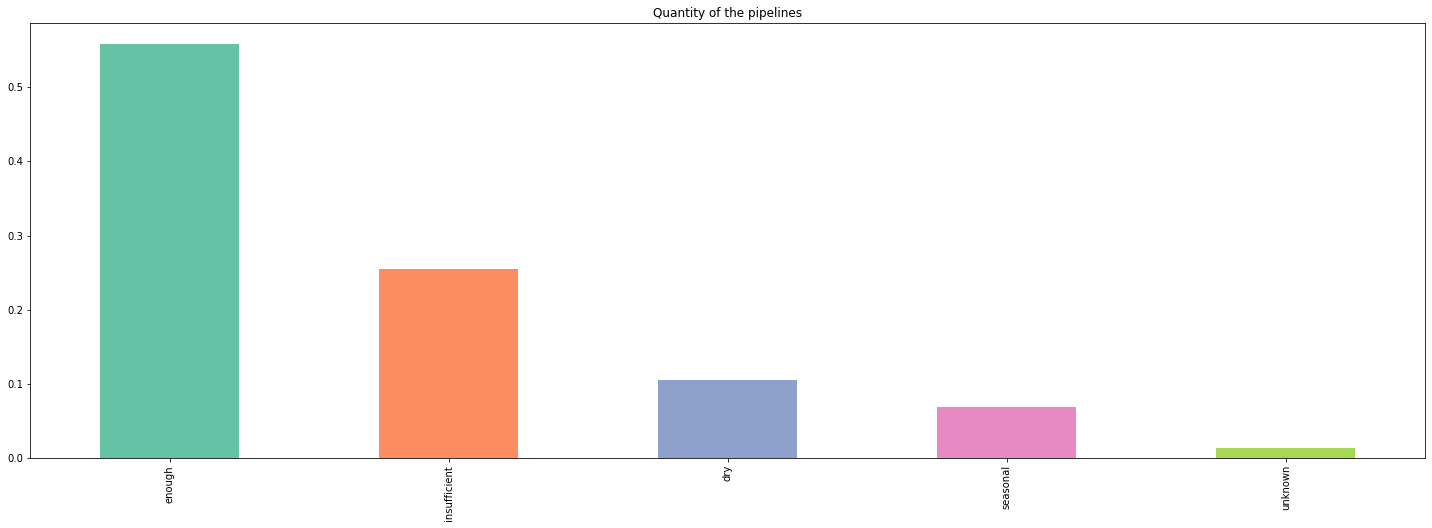

In [22]:
fig = plt.figure(figsize=(25,8))  
train_data.quantity.value_counts(normalize="True").plot(kind="bar", title="Quantity of the pipelines", color=my_cmap.colors);

> Die Grafik veranschaulicht den Status der jeweiligen Brunnen. Knapp 60% liefern genug Wasser. Etwa 25% sind insuffizient und knapp 12% sind trocken. Von weniger als 10% ist bekannt, dass die Funktionalität Saison bedingt und somit an die Regenzeit gebunden ist. Ebenfalls gibt es ein paar wenige Brunnen von denen keine Informationen vorliegen.

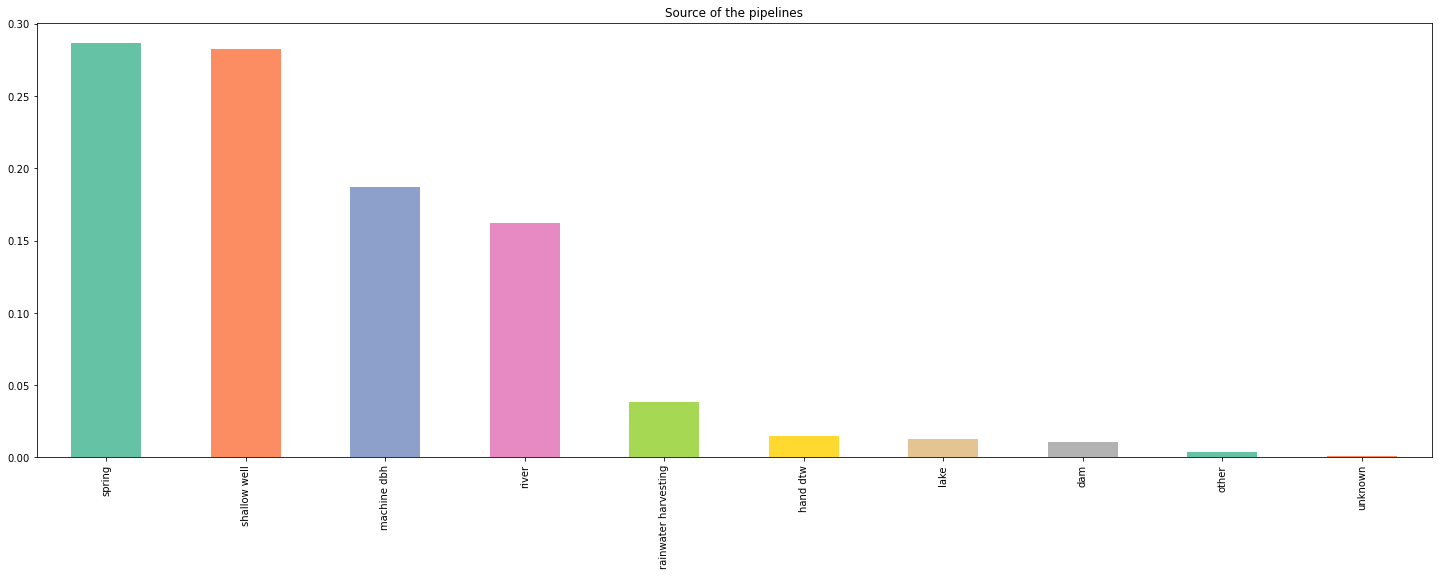

In [23]:
fig = plt.figure(figsize=(25,8))  
train_data.source.value_counts(normalize="True").plot(kind="bar", title="Source of the pipelines", color=my_cmap.colors);

>Die Brunnen beziehen sich auf unterschiedliche Quellen wie oben zu sehen ist. Vorreiter mit knapp 30% sind 'spring' und 'shallow well'. Dies zeigt den natürlichen Ursprung des Wassers.

#### Korrelations-Heatmap

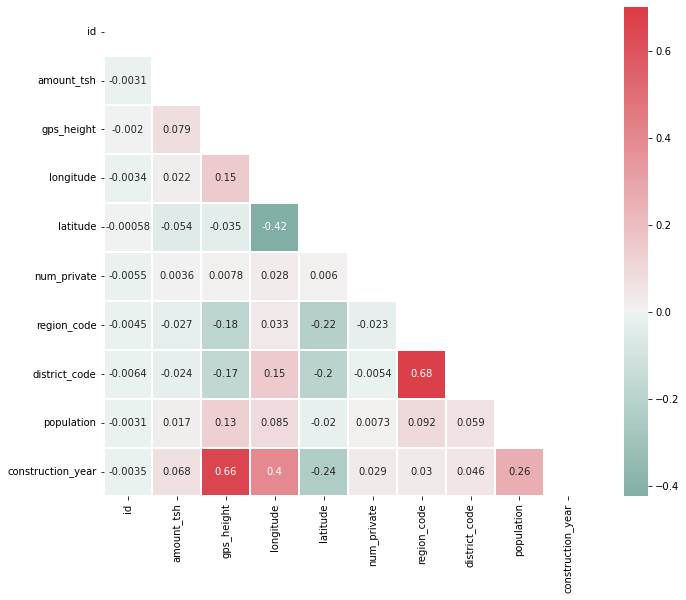

In [24]:
# Compete the correlation matrix
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(7010, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0,
                     vmax=.7, linewidths=0.01, annot=True, square=True, ax=ax) #eventuell linewidths=.5,
plt.show();

>Die deutlichsten Korrelationen zeigen sich zwischen den Längen- und Breitengraden mit einem Wert von - 0.42, dem 'district_code' und 'region_code' mit einem Wert von 0.68 sowie zwischen dem 'gps_height' und dem 'construction_year' mit einem Wert von 0.66.

> Wichtig hierbei ist, dass alle Werte einen Einfluss auf einander haben und man auf Grund einer geringen Korrelation nicht sagen kann, das bestimmte Werte irrelevant sind.

> Die Korrelationen zwischen den numerischen Werten sagen momentan nicht besonders viel aus, da es hauptsächlich hohe Korrelationen zwischen den geographischen Merkmalen wie Longitude and Lattitude bspw. gibt

#### Geographische Daten
>Analysierte Spalten: gps_height, longitude, latitude, subvillage, region, region_code, district_code


In [25]:
fig = px.scatter_mapbox(train_data, lat="latitude", lon="longitude", color="status_group", opacity=0.7, mapbox_style="open-street-map")
fig.show()

> Aus der Karte lässt sich ablesen, dass es sich hauptsächlich um Brunnen in dem afrikanischen Land Tansania handelt. Bei genauerer Betrachtung des einen Datenpunkts ganz weit links in der Karte wird klar, dass es sich hierbei um einen "Ausreißer" handeln muss, da in seiner Lattitude ein Buchstabe 'n' befindet, was die geographische Lage verfälscht.

#### Betrachtung der Höhenmeter / Elevation in Tansania in Bezug auf das Attribut gps_height

<img src="elevation_tanzania.jpeg" alt="Alternative text" />

In [26]:
print(f'{(train_data.gps_height==0).sum()/len(train_data)*100:.2f} % der Datenpunkte sind bei genau 0, was für gegebene Höhenmeter in Tansania (s. Bild oben) eher unrealistisch ist')

34.34 % der Datenpunkte sind bei genau 0, was für gegebene Höhenmeter in Tansania (s. Bild oben) eher unrealistisch ist


In [27]:
# that's why we replace the zeroes of gps_height with NaN 
train_data.loc[train_data["gps_height"]<=0, "gps_height"] = np.nan
test_data.loc[test_data["gps_height"]<=0, "gps_height"] = np.nan

In [28]:
train_data.gps_height.describe()

count    31877.000000
mean      1061.562914
std        586.857746
min          1.000000
25%        473.000000
50%       1197.000000
75%       1512.000000
max       2770.000000
Name: gps_height, dtype: float64

In [29]:
# checking how many values in gps_height are still 0:
print(f'{(train_data.gps_height==0).sum()/len(train_data)*100:.2f} % der Datenpunkte sind bei genau 0.')

0.00 % der Datenpunkte sind bei genau 0.


In [30]:
# converting 'date_recorded' to numerical values in train and test dataset
dr = pd.to_datetime(train_data.date_recorded)
train_data["date_recorded"] = dr.dt.year + dr.dt.month/12
dr = pd.to_datetime(test_data.date_recorded)
test_data["date_recorded"] = dr.dt.year + dr.dt.month/12

In [31]:
# replacing the 0s in construction_year with NaN in test and data set, so it won't be interpreted as zeroes
train_data.loc[train_data["construction_year"]==0, "construction_year"] = np.nan
test_data.loc[test_data["construction_year"]==0, "construction_year"] = np.nan

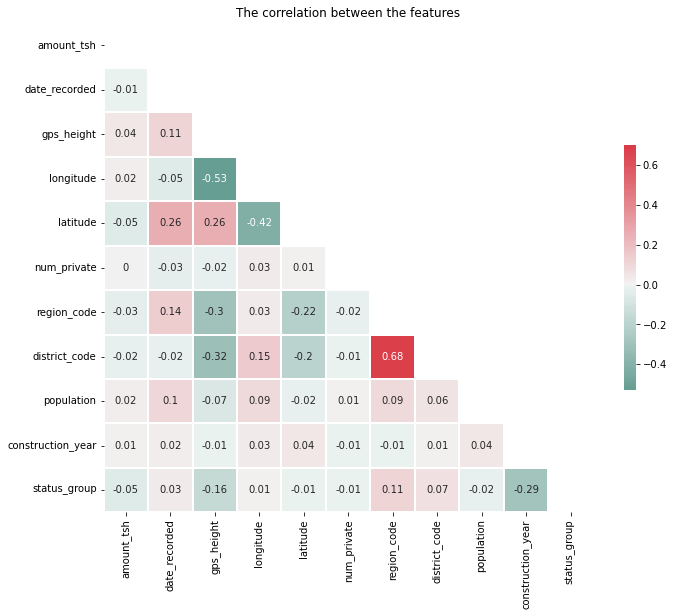

In [32]:
# plotting another correlation matrix to see if there are now other correlations
corr_matrix = train_data.copy()
# adding status_group to the correlation map
corr_matrix["status_group"] = corr_matrix["status_group"].map({"functional": 0, "non functional": 2, "functional needs repair": 1})
# show heatmap of correlations without id and hide the upper triangle
corr_matrix = corr_matrix.corr()
corr_matrix = corr_matrix.drop("id").drop("id", axis=1).round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(7010, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=0.7, center=0, annot=True,
            square=True, linewidths=.01, cbar_kws={"shrink": .5})
plt.title('The correlation between the features');

>Die Heatmap zeigt nochmals eine andere Darstellungsmöglichkeit der Korrelation. Dabei wurden auch die Attribute 'date_recorded' und 'status_group' miteinbezogen, indem sie in numerische Werte umgewandelt wurden. Dadurch lassen sich weitere Korrelationen ablesen.

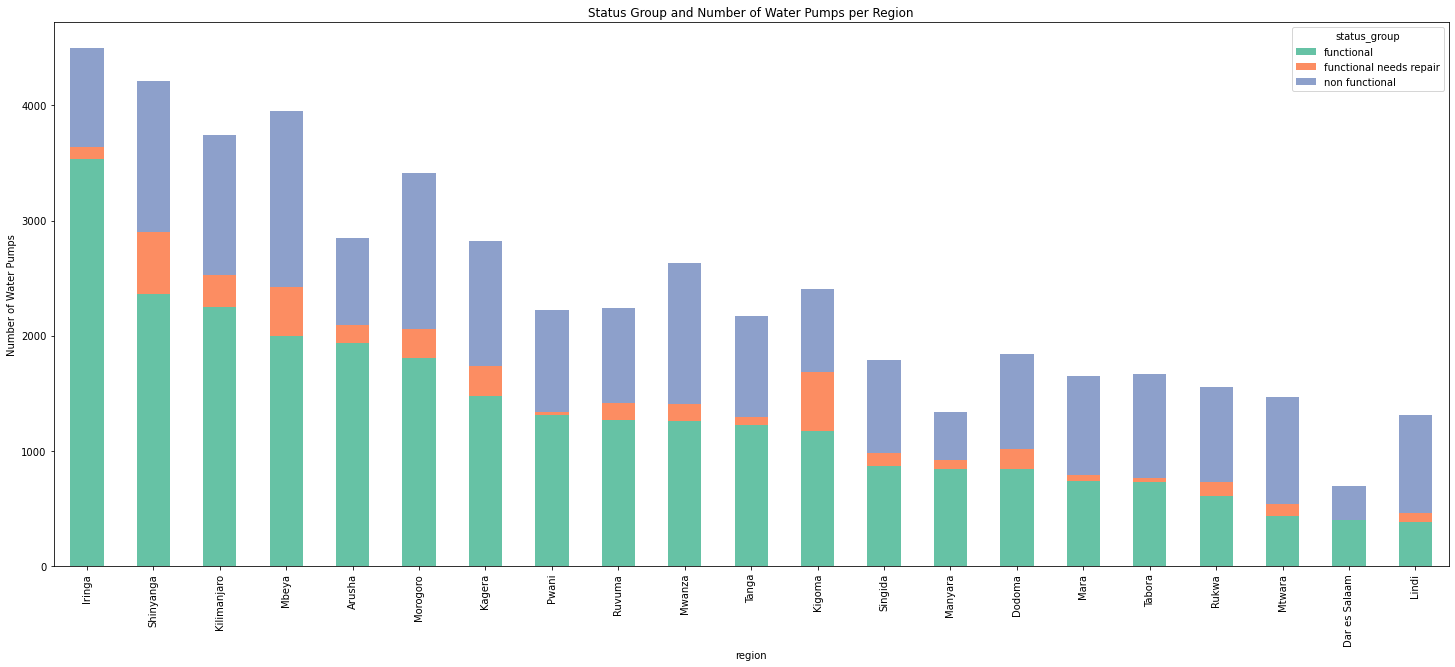

In [33]:
df_plot = train_data.groupby(['region', 'status_group']).size().reset_index().pivot(columns='status_group', index='region', values=0).sort_values('functional', ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Region', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Diese Grafik zeigt den Zusammenhang zwischen der Anzahl der bestehenden Brunnen je Region im Bezug zu deren Funktionalität. Allgemein lässt sich ungefähr sagen, dass etwa die Hälfte der Brunnen je Region nicht funktionsfähig ist. In Iringa befinden sich die meisten Brunnen, gefolgt von Shinyango und Mbeya. In Shinyango, Kigoma und Mbeya befinden sich auch die meisten Brunnen, die repariert werden sollten. Ebenfalls in Mbeya, Shinyanga, Morogoro und Kilimanjaro sind die meisten Brunnen, die nicht funktionsfähig sind. Es zeigt sich, dass desto mehr Brunnen in einer Region installiert sind, desto größer ist die Wahrscheinlichkeit, dass diese nicht funktionsfähig sind.

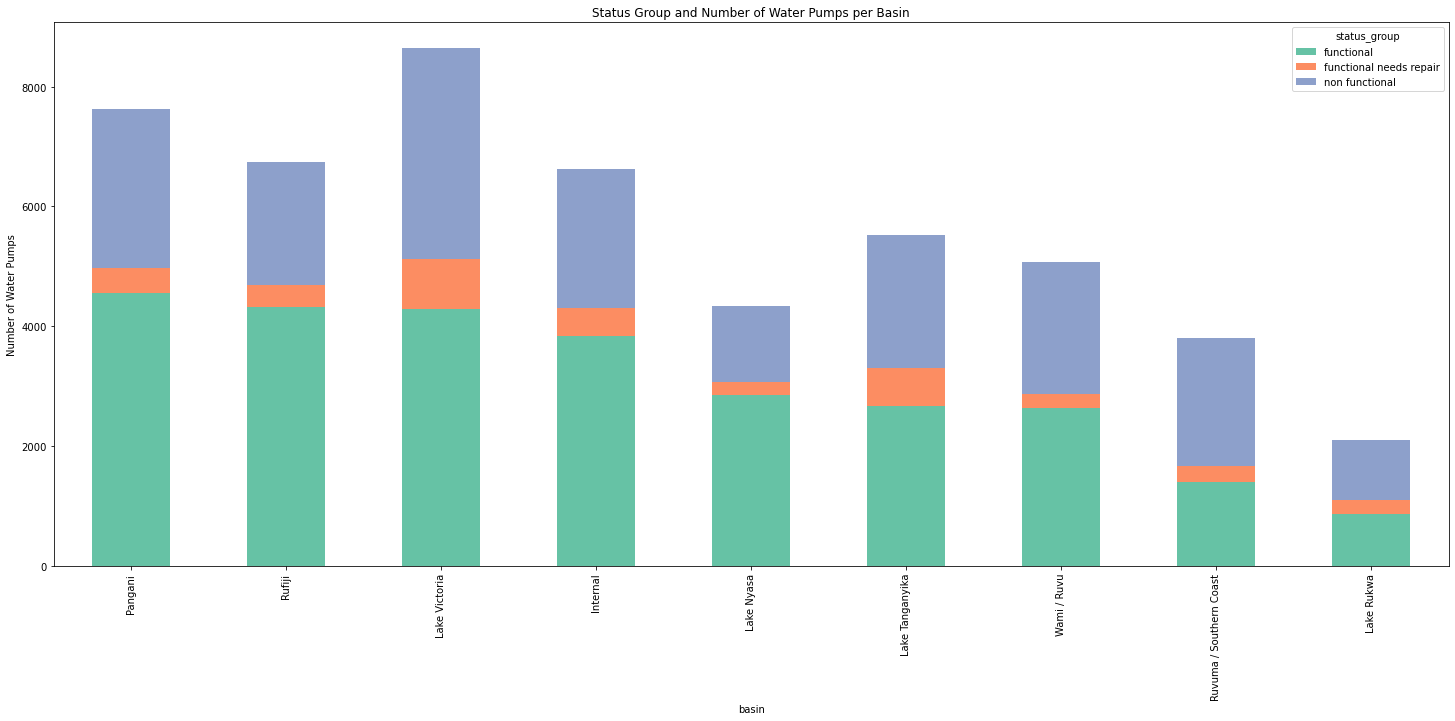

In [34]:
df_plot = train_data.groupby(['basin', 'status_group']).size().reset_index().pivot(columns='status_group', index='basin', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Basin', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Dieses Diagramm zeigt die Verteilung des Attributes 'status_group' in Bezug auf die Quelle. Es fällt auf, dass 'Basin' nicht besonders viel Einfluss auf die 'status_group' hat.

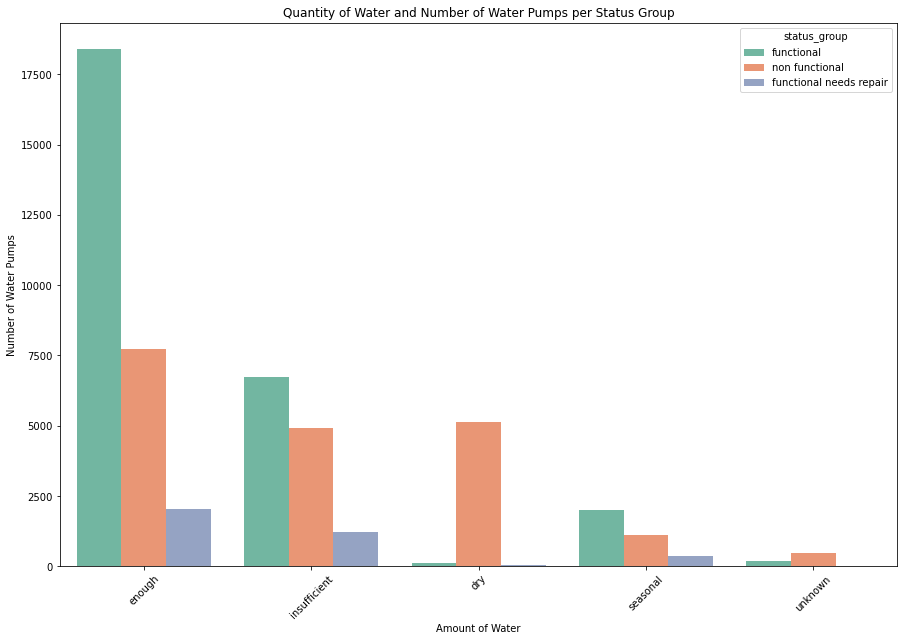

In [35]:
fig = plt.figure(figsize=(15,10))  
plot = sns.countplot(data=train_data, x='quantity', hue='status_group', palette="Set2")
plot.set(xlabel='Amount of Water', ylabel='Number of Water Pumps', title='Quantity of Water and Number of Water Pumps per Status Group')
plt.xticks(rotation=45);

>Dieses Chart stellt die Beziehung zwischen der Funktionalität der Brunnen und des Wasservorkommens dar. In den Regionen, in denen genug Wasser vorhanden ist, befinden sich die meisten funktionsfähigen Brunnen. Etwas mehr als die Hälfte in diesem Gebiet ist nicht funktionsfähig. In Bereichen, in denen das Wasservorkommen insuffizient ist, ist die Verteilung von funktionsfähig und nicht funktionsfähig sehr ausgeglichen. In wasserlosen Gebieten ist kein Brunnen funktionsfähig. In Bereichen in denen es ein saisonales Wasservorkommen gibt, ist die Verteilung der Funktionalität ebenfalls ausgeglichen.


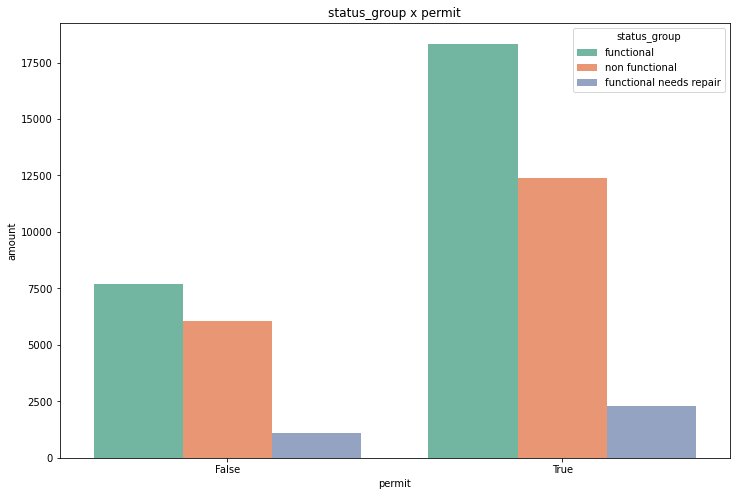

In [36]:
plt.figure(figsize=(12,8))
attrition_counts = (train_data.groupby(['permit'])['status_group']
                     .value_counts()
                     .rename('amount')
                     .reset_index()
                     .sort_values('permit'))
plt.title('status_group x permit')
sns.barplot(x="permit", y="amount", hue="status_group", data=attrition_counts, palette="Set2");

>Die Grafik verdeutlicht den Zusammenhang zwischen 'permit' und den 'status_group' Werten. Es zeigt sich, dass eine Kausalität nicht zu vermuten ist.
>Dieses Barchart verschafft einen Überblick über die rechtliche Sachlage. Knapp 70% sind genehmigte Brunnen. Etwas mehr als 30% jedoch nicht. Dies macht es schwierig, Wartungen und gute Bedingungen zu garantieren.

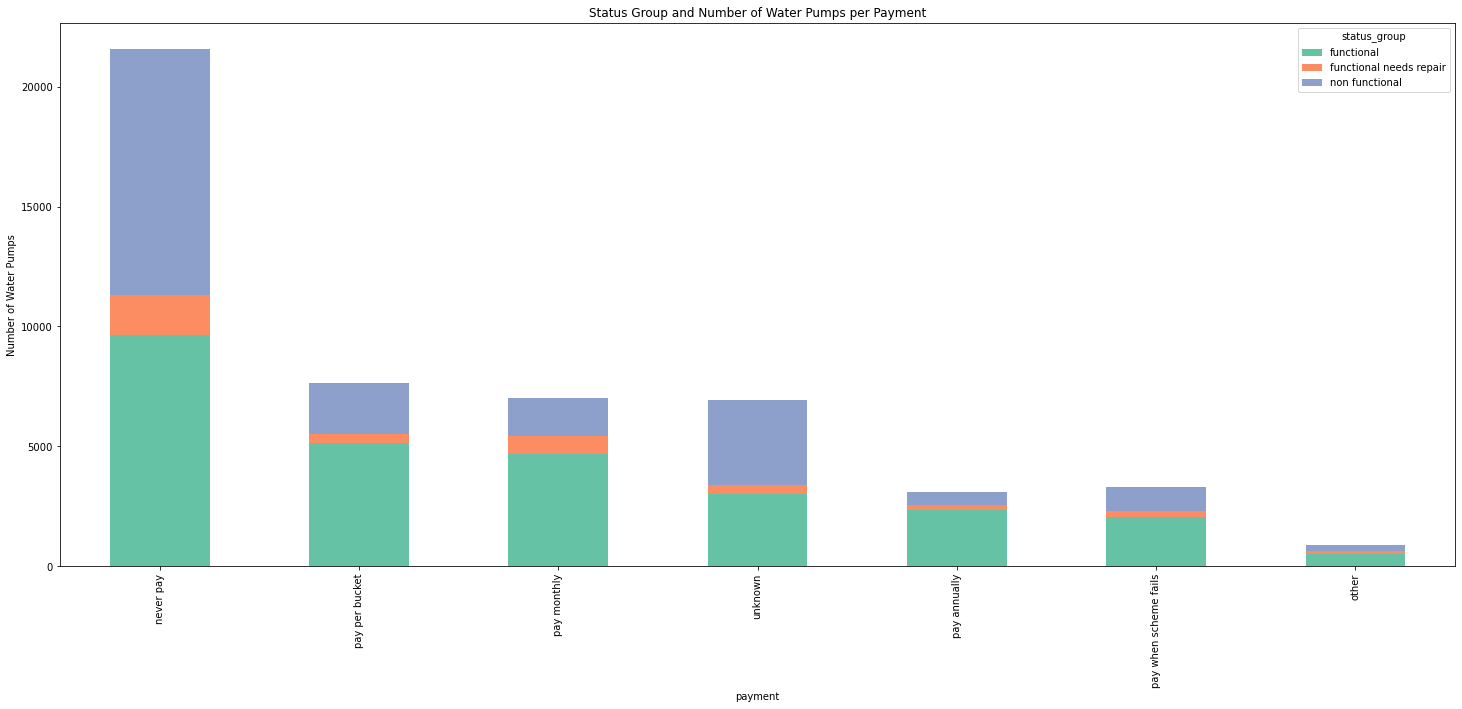

In [37]:
df_plot = train_data.groupby(['payment', 'status_group']).size().reset_index().pivot(columns='status_group', index='payment', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Payment', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Es ist zu erkennen, dass vor allem die Payment types 'never pay' und 'unknown' viele Brunnen, die nicht functional sind, aufzeigen.

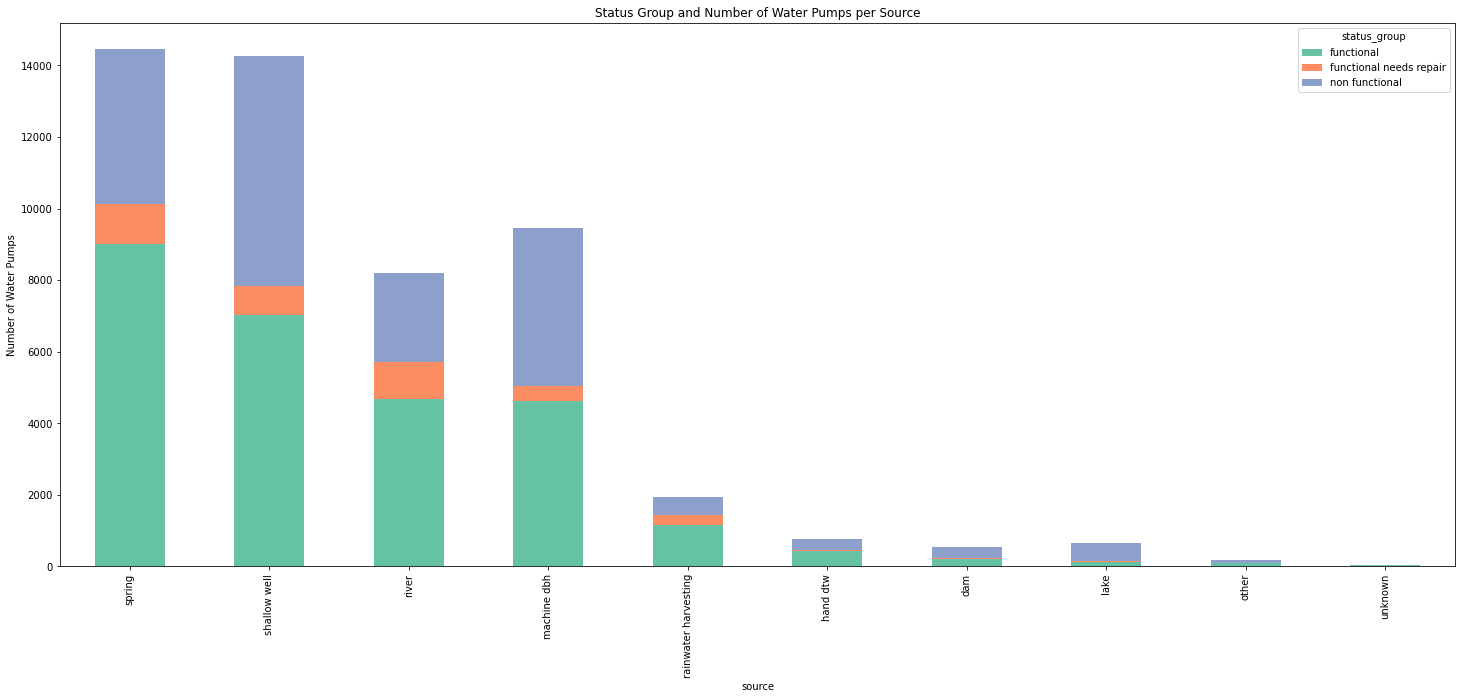

In [38]:
df_plot = (train_data.groupby(['source', 'status_group']).size().reset_index().pivot(columns='status_group', index='source', values=0)).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Source', ylabel='Number of Water Pumps', color=my_cmap.colors);

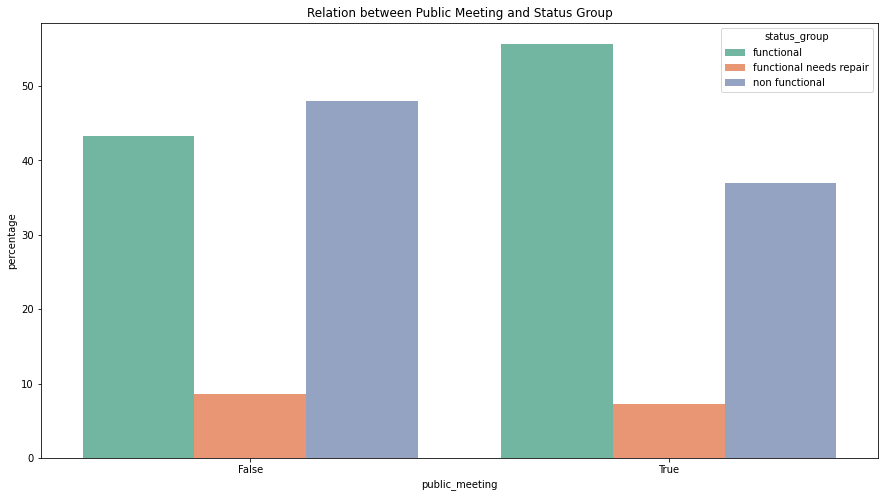

In [39]:
plt.figure(figsize=(15,8))
attrition_counts = (train_data.groupby(['public_meeting'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
plt.title('Relation between Public Meeting and Status Group')
sns.barplot(x="public_meeting", y="percentage", hue="status_group", data=attrition_counts, palette="Set2");

In [40]:
# function for plotting pie charts for each given category
colors = ['#66c2a5', '#ff0000', '#fc8d62']
def plot_multiple_pie_by_category(df, category, n_max=None, n_cols=3, max_height=900, max_width=1800):
    if n_max is None:
        categories = df[category].unique()
    else:
        categories = df[category].value_counts().index.tolist()[:n_max]
    
    n_rows = len(categories)
    fig = make_subplots(rows=len(categories)//n_cols, cols=n_cols, specs=[[{"type": "pie"}]*n_cols]*(len(categories)//n_cols))
    for i, label in enumerate(categories):
        df_label = df[df[category] == label]
        fig.add_trace(go.Pie(labels=df_label["status_group"].unique(), marker=dict(colors=colors),
        values=df_label["status_group"].value_counts(), 
        name=label, title=f"{label}: {len(df_label)} pumps"), row=i//n_cols+1, col=i%n_cols+1)
    fig.update_layout(height=max(max_height, n_rows*50), width=max_width, title=f"Status_group by {category}")
    fig.show()

In [41]:
plot_multiple_pie_by_category(train_data, "management", n_max=24, n_cols=4, max_height=300, max_width=1000)

>Die Brunnen werden von 12 unterschiedlichen Organisationen gemanaged. Vorreiter ist 'VWC' mit knapp 70% der Brunnen (34383). Mit weitem Abstand folgt 'WUG' mit knapp über 10% der Brunnen (5534). Die anderen 10 Organisationen pendeln sich im Bereich von unter 10% ein. An sich hat das Management keinen großen Einfluss auf die 'status_group'.

In [42]:
plot_multiple_pie_by_category(train_data, "water_quality", n_max=8, n_cols=4, max_height=500, max_width=1000)

> Die Wasserart der meisten (43191) Brunnen ist 'soft'. Auffällig ist, dass die 'water_quality' salty, coloured, fluoride abandoned und milky eine hohe Rate an non functional Brunnen haben. Auch sind viele Brunnen, wo die 'water_quality' unknown ist, functional. 

In [43]:
plot_multiple_pie_by_category(train_data, "funder", n_max=8, n_cols=4, max_height=500, max_width=1000)

>Mit Hilfe dieser Pie Charts ist es möglich einen schnellen und aufschlussreichen Überblick über die Abhängigkeit des Merkmals Funder zu 'status_group' zu erhalten. Jedoch ist diese Abhängigkeit nicht besonders groß, da der Funder wie man in den Pie Charts erkennen kann bis zu keinen Einfluss auf die 'status_group' hat.

In [44]:
plot_multiple_pie_by_category(train_data, "installer", n_max=8, n_cols=4, max_height=500, max_width=1000)

> In diesem Chart erkennt man die Abhängigkeit von 'status_group' zu dem Attribut installer. Auffällig ist, dass manche (675) installer als 0 gekennzeichnet sind und deshalb eventuell fehlende Werte darstellen. Allgemein sieht man aber, dass 'installer' nicht besonders viel Einfluss auf die 'status_group' hat, das die Verteilung der 'status_group' bei jedem 'installer' ungefähr gleich ist.

#### Verteilung des Merkmals status_group bei Größe der Bevölkerung

In [45]:
px.box(train_data[train_data['population']!=0], x="population", y="status_group", range_x=[0,10000])

> Die 'population' hat insgesamt 18142 0-Werte, welche aus diesem Diagramm herausgefiltert wurden, um die Abhängigkeit der 'status_group' von der 'population' genauer zu visualisieren. Trotzdem fällt auf, dass die 'population' zum Einen prinzipiell sehr niedrige Werte besitzt und insgesamt keinen großen Einfluss auf die 'status_group' hat. Generell sollten die 0-Werte in einem späteren Schritt, der Data Preparation, eventuell genauer betrachtet werden.

### Bewertung der Daten: 
An diesem Punkt wird die Qualität des Datenbestandes bewertet. Es soll festgestellt werden, ob die Datenmenge für die Analyse ausreichend und verwendbar ist, wobei besonders auf fehlende Attributwerte zu achten ist.
> Aus der vorangegangenen Analyse des Datensatzes im Rahmen des Data Understandings kann festgestellt werden, dass die Daten vor der weiteren Verarbeitung/ Verwendung im nächsten Schritt durch die Data Preparation bereinigt und aufbereitet werden müssen.

## Data Preperation

### Auswahl der Daten:
Die Auswahl der Daten für das Data Mining hängt stark von den Zielen ab, die man für das Data Mining-Projekt definiert. Hier spielen die Datenqualität und die technischen Gegebenheiten eine große Rolle. Es wird eine Selektion der Daten vorgenommen. Am Ende dieses Prozesses sollte sich deutlich zeigen, welche Datenmengen(-Sets) in die Analyse aufgenommen werden oder ausgeschlossen werden.

In [46]:
df = train_data
numerical_cols = [col for col in df.columns if type(df.loc[0, col]) in [np.int64, np.float64]]
for col in [
    # id and num_private have a relatively low selectivity
    "id",
    "num_private",
    # removing geographical attributes because they are also encoded by long and lat 
    "region_code",
    "district_code"
]:
    numerical_cols.remove(col)

numerical_cols

['amount_tsh',
 'date_recorded',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'construction_year']

In [47]:
cat_cols = [col for col in df.columns if type(df.loc[0, col]) not in [np.int64, np.float64]]
for col in [
#    "funder",
#    "installer",
    "wpt_name",
    # removing the following four attributes because they are geographical
    "subvillage",
    "region",
    "lga",
    "ward",
    "funder",
    "installer",
    #
    "scheme_name",
    # removing status_group because it's the label
    "status_group",
    # low selectivy of recorded_by as all pumps have been recorded by the same person
    "recorded_by",
    # redundant attributes
    'waterpoint_type_group',                  
    'extraction_type_group',
    'extraction_type_class',
    'payment_type',
    'quantity_group',
    'source_type',
    'source_class',
    'management_group'
]:
    cat_cols.remove(col)
cat_cols

['basin',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type']

### Bereinigung der Daten: 
Ohne eine Bereinigung der Daten ist ein erfolgreiches Data Mining-Projekt fraglich. Es gilt, eine saubere Datenmenge auszuwählen oder die Datenmenge muss bereinigt sein, um das gewünschte Ergebnis in der Modellierung zu erreichen.
Um die Daten in eine brauchbare Darstellungsform zu bringen, transformiert man die Daten. Die Transformation kodiert Daten und verändert deren Granularität durch Aggregation oder Disaggregation.
>Bei der folgenden Bereinigung werden die Nullwerte durch den Median bzw. dem Modus der jeweiligen Spalte ersetzt.

>Die Dataframes werden in Numpy Arrays konvertiert für die folgende Übergabe an die Modelle.


##### Bereinigung des Trainingsdatensatzes:

In [48]:
class Dataset:
    def __init__(self, encoder="onehot", normalizer="minmax"):
        self.feature_arrays = []
        self.feature_names = []
        self.label_array = []
        self.enc_dict = {}
        self.encoder_class = OneHotEncoder if encoder == "onehot" else OrdinalEncoder
        self.normalizer_class = MinMaxScaler if normalizer == "minmax" else StandardScaler

    def add_feature(self, feature_array, name):
        self.feature_arrays.append(feature_array)
        for i in range(feature_array.shape[1]):
            self.feature_names.append(name + str(i))
    
    def add_label(self, label_array):
        if len(label_array.shape) == 1:
            label_array = label_array.reshape(-1, 1)
        else:
            self.label_array = label_array

    def get_data(self):
        return np.hstack(self.feature_arrays), self.label_array.flatten(), self.feature_names

    def reset_for_test(self):
        self.feature_arrays = []
        self.feature_names = []
        self.label_array = []


    def encode(self, df, column_name, mode="train", top_n=None):
        if mode == "train": 
            encoder = self.encoder_class(sparse=False)
            encoder = encoder.fit(df[column_name].values.reshape(-1, 1))
            self.enc_dict[column_name] = (top_n, encoder)
        else:
            top_n, encoder = self.enc_dict[column_name]

        if top_n:
            return encoder.transform(df[column_name].values.reshape(-1, 1))[:, :top_n]
        else:
            return encoder.transform(df[column_name].values.reshape(-1, 1))

    def normalize(self, df, column_name, mode="train"):
        if mode == "train":
            normalizer = self.normalizer_class()
            normalizer = normalizer.fit(df[column_name].values.reshape(-1, 1))
            self.enc_dict[column_name] = normalizer
        else:
            normalizer = self.enc_dict[column_name]
        return normalizer.transform(df[column_name].values.reshape(-1, 1))


In [49]:
ds = Dataset(encoder="onehot", normalizer="standard")
# continous variables
for var in numerical_cols:
    df[var] = df[var].fillna(df[var].mean())
    vals = ds.normalize(df, var, mode="train")
    ds.add_feature(vals, var)

In [50]:
# encodings
top_n = 30
for var in cat_cols:
    df[var] = df[var].fillna(df[var].mode())
    vals = ds.encode(df, var, mode="train", top_n=top_n)
    ds.add_feature(vals, var)

In [51]:
label_arr = LabelEncoder().fit_transform(df["status_group"]).reshape(-1, 1)

ds.add_label(label_arr)

In [52]:
X, y, names = ds.get_data()

#### Bereinigung des Testdatensatzes:

In [53]:
ds.reset_for_test()

In [54]:
# continous variables
for var in numerical_cols:
    test_data[var] = test_data[var].fillna(df[var].mean())
    vals = ds.normalize(test_data, var, mode="test")
    ds.add_feature(vals, var)

In [55]:
# encodings
top_n = 30
for var in cat_cols:
    test_data[var] = test_data[var].fillna(df[var].mode())
    vals = ds.encode(test_data, var, mode="test", top_n=top_n)
    ds.add_feature(vals, var)

In [56]:
label_arr = LabelEncoder().fit_transform(test_data["status_group"]).reshape(-1, 1)
ds.add_label(label_arr)

In [57]:
X_test, y_test, names_test = ds.get_data()

## Modeling

### Auswahl der Modellierungstechnik: 
Hier gilt es eine Modellierungstechnik auswählen, mit der man das Modell erstellt
>Für die Modellauswahl werden 12 unterschiedliche Modelle betrachtet. Dabei werden drei Dummy Modelle erstellt (AllOnes, AllZeros, Random).

In [86]:
class RandomPredictor:
    def __init__(self):
        self.__class__.__name__ = "----RANDOM----"
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.random.randint(0, 2, len(X))

    def predict_proba(self, X):
        return np.array([1/3, 1/3, 1/3]*len(X)).reshape(-1, 3)

class AllZeros:
    def __init__(self):
        self.__class__.__name__ = "----ALL 0's----"
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.zeros(X.shape[0])

    def predict_proba(self, X):
        return np.array([1, 0, 0]*len(X)).reshape(-1, 3)

class AllOnes:
    def __init__(self):
        self.__class__.__name__ = "----ALL 1's----"
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.ones(X.shape[0])
    def predict_proba(self, X):
        return np.array([0, 1, 0]*len(X)).reshape(-1, 3)

def one_vs_all(y, target=0):
    if target == None:
        return y
    y_ = y.copy()
    y_[y!=target] = 0
    y_[y==target] = 1
    return y_

In [59]:
models = [
    RandomPredictor(),
    AllZeros(),
    AllOnes(),
    DecisionTreeClassifier(), 
    GaussianNB(), 
    LogisticRegression(max_iter=300),
    # SVC(max_iter=300, probability=True), 
    RandomForestClassifier(), 
    KNeighborsClassifier(), 
    # SGDClassifier(loss="modified_huber"), 
    XGBClassifier()
]

In [60]:
scores = {
    "model_name": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "accuracy": [],
    "roc_auc": [],
    "target": []
}

In [61]:
metrics = [
    ("f1_score", lambda y_true, y_pred, y_prob: f1_score(y_true, y_pred)),
    ("precision", lambda y_true, y_pred, y_prob: precision_score(y_true, y_pred, zero_division=0)),
    ("recall", lambda y_true, y_pred, y_prob: recall_score(y_true, y_pred, zero_division=0)),
    ("accuracy", lambda y_true, y_pred, y_prob: accuracy_score(y_true, y_pred)),
    ("roc_auc", lambda y_true, y_pred, y_prob: roc_auc_score(y_true, y_prob))
]

targets = [0, 1, 2]

In [62]:
for model, target in tqdm(product(models, targets), total=len(models)*len(targets)):
    y_target = one_vs_all(y, target=target)
    y_target_test = one_vs_all(y_test, target=target)
    model = model.fit(X, y_target)
    y_prob, y_pred = get_prob_and_pred(model, X_test)
    scores["model_name"] += [model.__class__.__name__]
    scores["target"] += [target]
    for name, function in metrics:
        scores[name] += [function(y_target_test, y_pred, y_prob)]

 59%|█████▉    | 16/27 [00:04<00:05,  2.16it/s]c:\Users\ibele\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

100%|██████████| 27/27 [01:02<00:00,  2.32s/it]


In [63]:
scores = pd.DataFrame(scores)

In [64]:
scores.loc[scores["target"]==0].sort_values("roc_auc", ascending=False)

model_name  f1_score  precision    recall  accuracy   roc_auc  \
18  RandomForestClassifier  0.841849   0.825169  0.859216  0.825253  0.897784   
24           XGBClassifier  0.828052   0.783744  0.877670  0.802694  0.885493   
21    KNeighborsClassifier  0.821583   0.799882  0.844495  0.801459  0.864371   
15      LogisticRegression  0.789554   0.728404  0.861912  0.751291  0.822168   
9   DecisionTreeClassifier  0.799670   0.794919  0.804479  0.781818  0.780419   
12              GaussianNB  0.765285   0.693383  0.853825  0.716498  0.772879   
0           ----RANDOM----  0.702396   0.541302  1.000000  0.541302  0.500000   
3          ----ALL 0's----  0.000000   0.000000  0.000000  0.458698  0.500000   
6          ----ALL 1's----  0.702396   0.541302  1.000000  0.541302  0.500000   

    target  
18       0  
24       0  
21       0  
15       0  
9        0  
12       0  
0        0  
3        0  
6        0

In [65]:
scores.loc[scores["target"]==1].sort_values("roc_auc", ascending=False)

model_name  f1_score  precision    recall  accuracy   roc_auc  \
25           XGBClassifier  0.346154   0.750000  0.225000  0.938945  0.876029   
19  RandomForestClassifier  0.425229   0.609329  0.326562  0.936588  0.867474   
22    KNeighborsClassifier  0.405512   0.547872  0.321875  0.932211  0.803859   
16      LogisticRegression  0.006173   0.250000  0.003125  0.927722  0.781997   
10  DecisionTreeClassifier  0.360063   0.362342  0.357812  0.908642  0.670517   
13              GaussianNB  0.156334   0.085163  0.951562  0.262290  0.613747   
1           ----RANDOM----  0.134031   0.071829  1.000000  0.071829  0.500000   
4          ----ALL 0's----  0.000000   0.000000  0.000000  0.928171  0.500000   
7          ----ALL 1's----  0.134031   0.071829  1.000000  0.071829  0.500000   

    target  
25       1  
19       1  
22       1  
16       1  
10       1  
13       1  
1        1  
4        1  
7        1

In [66]:
scores.loc[scores["target"]==2].sort_values("roc_auc", ascending=False)

model_name  f1_score  precision    recall  accuracy   roc_auc  \
20  RandomForestClassifier  0.808433   0.847107  0.773136  0.858249  0.918667   
26           XGBClassifier  0.769949   0.864211  0.694227  0.839506  0.904820   
23    KNeighborsClassifier  0.771236   0.817886  0.729620  0.832548  0.883067   
17      LogisticRegression  0.693659   0.819368  0.601393  0.794501  0.842518   
11  DecisionTreeClassifier  0.764731   0.763295  0.766173  0.817621  0.807971   
14              GaussianNB  0.661407   0.725009  0.608065  0.759147  0.796436   
2           ----RANDOM----  0.557902   0.386869  1.000000  0.386869  0.500000   
5          ----ALL 0's----  0.000000   0.000000  0.000000  0.613131  0.500000   
8          ----ALL 1's----  0.557902   0.386869  1.000000  0.386869  0.500000   

    target  
20       2  
26       2  
23       2  
17       2  
11       2  
14       2  
2        2  
5        2  
8        2

### Testmodell erstellen: 
Nach Auswahl des Modells wird ein Testmodell erstellt, um Qualität und Genauigkeit des Modells zu überprüfen. In überwachten Verfahren, wie der Klassifikation, ist es üblich, die Fehlerraten als Qualitätsmaß zu nutzen.
>Aus den vorangegangenen Analysen geht hervor, dass der RandomForestClassifier bei allen drei Modellen, die beste Performance aufzeigt. Daher wird dieses Modell im folgenden weiter optimiert um die bestmöglichen Resultate zu erzielen.

In [67]:
param_grid = {
    'n_estimators': [40, 100, 200],
    'max_samples': [0.5, 0.8, 0.99]
}

In [68]:
models = []
for target in tqdm(targets):
    gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3, scoring="roc_auc")
    y_target = one_vs_all(y, target=target)
    gs.fit(X, y_target)
    model = gs.best_estimator_
    model = model.fit(X, y_target)
    models.append(model)

100%|██████████| 3/3 [05:18<00:00, 106.29s/it]


In [69]:
class MultiLabelClassifier:
    def __init__(self, classifiers):
        self.classifiers = classifiers

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

    def predict_proba(self, X):
        preds = np.zeros((X.shape[0], len(self.classifiers)))
        for target, classifier in enumerate(self.classifiers):
            preds[:, target] = classifier.predict_proba(X)[:, 1]
        #normalize
        return preds / preds.sum(axis=1, keepdims=True)

In [70]:
mlc = MultiLabelClassifier(models)

In [71]:
# analyze mlc
y_pred = mlc.predict(X_test)
y_prob = mlc.predict_proba(X_test)
# calc accuracy
accuracy_score(y_test, y_pred)

0.813692480359147

In [72]:
def plot_roc(model, X, y, model_name="model"):
    y_pred_probs, _ = get_prob_and_pred(model, X)
    fpr, tpr, threshold = roc_curve(y, y_pred_probs, drop_intermediate=False)
    auc = roc_auc_score(y, y_pred_probs)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr)
    plt.title(f"ROC curve for {model_name}")
    plt.xlabel("1 - FP")
    plt.ylabel("TP")
    plt.fill_between(fpr, tpr, alpha=0.6)
    plt.text(x=.5, y=.5, s=f"{auc=:.2f}", fontsize=20)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # plot 3 thresholds for the model and add text to the plot
    for thresh in [0.2, 0.5, 0.7]:
        plt.plot(fpr[threshold == thresh], tpr[threshold == thresh], "o", color="black")
        plt.text(x=fpr[threshold == thresh]+0.03, y=tpr[threshold == thresh]+0.03, s=f"{thresh}", color="black", size=15)
    plt.show()

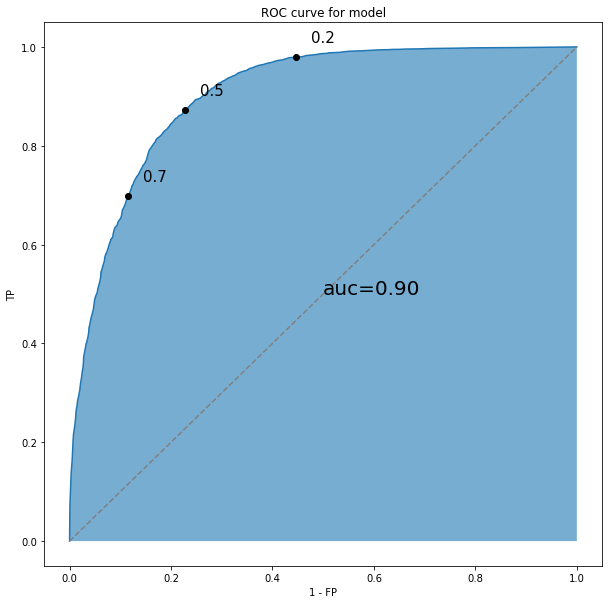

In [73]:
plot_roc(models[0], X_test, one_vs_all(y_test, target=0))

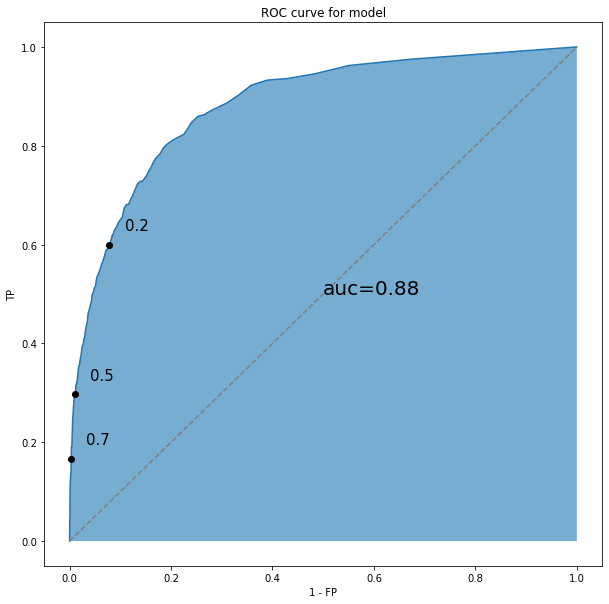

In [74]:
plot_roc(models[1], X_test, one_vs_all(y_test, target=1))

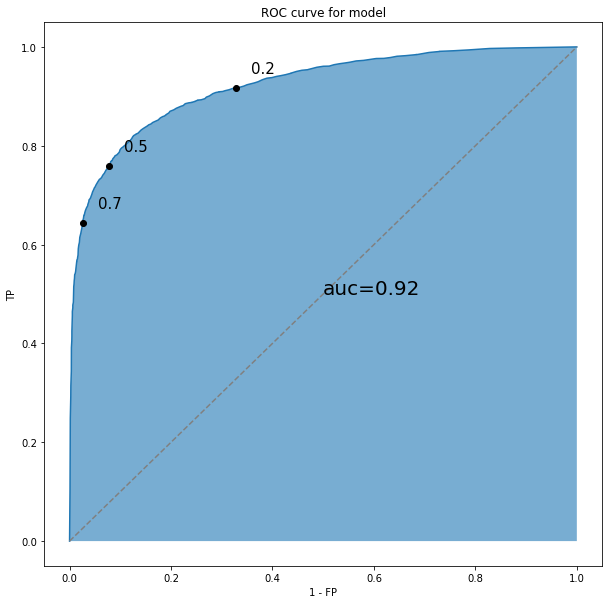

In [75]:
plot_roc(models[2], X_test, one_vs_all(y_test, target=2))

In [76]:
importance = model.feature_importances_
importance_dict = {}
for model in models:
    importances = model.feature_importances_
    for name, importance in zip(names, importances):
        # remove numerals from name
        name = "".join([c for c in name if not c.isdigit()])
        if name in list(importance_dict.keys()):
            importance_dict[name] += [importance]
        else:
            importance_dict[name] = [importance]
d = {"name": [], "importance": []}
for k, v in importance_dict.items():
    d["name"] += [k]
    d["importance"] += [sum(v)]
df = pd.DataFrame(d).groupby("name", as_index=False).sum().sort_values("importance", ascending=False)
px.pie(df, values="importance", names="name", title="Feature importance")

>Interpretation von f1, precision....
>Auswahl des besten Modells + Begründung

## Evaluation

### Bewertung des Modells: 
Hier ist das Modell nach der im Vorfeld definierten Data Mining-Zielsetzung zu bewerten. Des Weiteren gilt es die Data Mining-Ergebnisse in Bezug auf die Fragestellung zu bewerten.
>AUC Modell 1

>AUC Modell 2

>AUC Modell 3

### Bewerten der Resultate: 
In diesem Schritt bewertet man, inwieweit das Modell die Projektziele erreicht. Wenn die Ziele nicht erreicht sind, ist aufzuführen, aus welchen Gründen.
>Begründung warum das Modell eingesetzt werden sollte, positiver Effekt....

### Bewertung des Prozesses: 
Das Data Mining-Projekt wird rückblickend bewertet. Es wird festgestellt, ob alle wichtigen Faktoren betrachtet wurden und inwieweit die Attribute für zukünftige Data Mining-Projekte zu nutzen sind.
>Auffälligkeiten bei den Daten, Modellen, Ergebnissen

>Zusammenarbeit

## Deployment

Die Deployment-Phase bildet in der Regel die Endphase eines Data Mining-Projektes. Hier werden die gewonnenen Erkenntnisse so geordnet und präsentiert, sodass für den Auftraggeber die Möglichkeit besteht dieses Wissen zu nutzen. Dazu gehört eine eventuelle Implementierungsstrategie, die Überwachung der Gültigkeit der Modelle, ein zusammenfassender Bericht und eine Präsentation.
>Fazit



In [77]:
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions }) # kopiert aus NB1
output.to_csv('submission.csv', index=False)

pd.read_csv("submission.csv")

NameError: name 'ids' is not defined

In [ ]:
with open("pump_model.pkl", "wb") as f:
    dump(mlc, f)

Quellen:
<ul>
    <li>Quelle: https://datasolut.com/crisp-dm-standard/amp/</li>
</ul>